In [8]:
import re
from pathlib import Path
from typing import List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

# Load sentence-level embedding model
model = SentenceTransformer("all-MiniLM-L6-v2")


In [9]:
def load_book(filepath: str) -> str:
    """
    Load a plain-text novel from disk and remove common Project Gutenberg headers/footers.
    Returns the main book text as a single raw string.
    """
    with open(filepath, "r", encoding="utf-8") as f:
        text = f.read()

    # Clean Gutenberg header/footer if present
    start_match = re.search(r"\*\*\* START OF.*?\*\*\*", text)
    if start_match:
        text = text[start_match.end():]

    end_match = re.search(r"\*\*\* END OF.*?\*\*\*", text)
    if end_match:
        text = text[:end_match.start()]

    if "End of Project Gutenberg" in text:
        text = text[:text.find("End of Project Gutenberg")]

    return text.strip()


In [10]:
crime_path = "../data/Crime-punishment.txt"
crime_text = load_book(crime_path)

print(f"Loaded Crime and Punishment, total characters: {len(crime_text):,}")


Loaded Crime and Punishment, total characters: 1,209,409


In [11]:
def strip_gutenberg(text: str) -> str:
    """
    Very simple Project Gutenberg header/footer stripper.
    If you already have a better version in another notebook, 
    you can paste that here instead.
    """
    start_marker = "*** START OF THIS PROJECT GUTENBERG EBOOK"
    end_marker = "*** END OF THIS PROJECT GUTENBERG EBOOK"
    start_idx = text.upper().find(start_marker)
    end_idx = text.upper().find(end_marker)
    if start_idx != -1 and end_idx != -1:
        text = text[start_idx:end_idx]
    return text

def normalize_text(t: str) -> str:
    # 1) strip Gutenberg header/footer
    t = strip_gutenberg(t)
    # 2) normalize curly quotes
    t = t.replace("’", "'").replace("‘", "'")
    # 3) join hyphenated line breaks
    t = re.sub(r"-\s*\n", "", t)
    # 4) normalize whitespace
    t = re.sub(r"\s+", " ", t)
    return t.strip()

crime_text = normalize_text(raw_text)
print("Normalized characters:", len(crime_text))


Normalized characters: 1149797


In [12]:
# --- Split into chapters based on headings like "chapter i", "chapter 2", etc. ---

chapters_raw = re.split(r"\bchapter\s+[ivxlcdm0-9]+\b", crime_text, flags=re.IGNORECASE)
chapters = [ch.strip() for ch in chapters_raw if ch.strip()]

print("Total detected chapters:", len(chapters))

# Define Early (first 10) and Late (last 10)
early_chapters = chapters[:10]
late_chapters  = chapters[-10:]

early_text = " ".join(early_chapters)
late_text  = " ".join(late_chapters)

print("Early text length:", len(early_text))
print("Late text length:", len(late_text))


Total detected chapters: 41
Early text length: 286414
Late text length: 236351


In [16]:
# Example (adjust to your actual model name if different)
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("all-MiniLM-L6-v2")

def split_into_paragraphs(text: str, min_words: int = 10) -> List[str]:
    """
    Split raw text into paragraphs using blank lines as boundaries.

    Very short paragraphs (e.g. chapter titles) are filtered out by `min_words`.
    """
    text = text.replace("\r\n", "\n").replace("\r", "\n")
    raw_paras = re.split(r"\n\s*\n+", text)

    paragraphs = []
    for p in raw_paras:
        cleaned = re.sub(r"\s+", " ", p).strip()
        if not cleaned:
            continue
        if len(cleaned.split()) < min_words:
            continue
        paragraphs.append(cleaned)

    return paragraphs


def sentence_split(paragraph: str) -> List[str]:
    """
    Very simple sentence splitter for a single paragraph.
    """
    pieces = re.split(r"(?<=[.!?])\s+", paragraph)
    sentences = [s.strip() for s in pieces if len(s.strip().split()) > 2]
    return sentences


def cosine_similarity(u: np.ndarray, v: np.ndarray) -> float:
    """Cosine similarity between two embedding vectors."""
    denom = (np.linalg.norm(u) * np.linalg.norm(v)) or 1e-9
    return float(np.dot(u, v) / denom)


def paragraph_coherence_embeddings(paragraphs: List[str]) -> Tuple[List[str], List[float], List[int]]:
    used_paragraphs = []
    scores = []
    lengths = []

    for para in paragraphs:
        sents = sentence_split(para)

        if len(sents) < 1:
            continue

        # If one sentence, coherence = 1 (similar to itself)
        if len(sents) == 1:
            sent_embs = model.encode(sents)
            scores.append(1.0)
            lengths.append(len(sents[0].split()))
            used_paragraphs.append(para)
            continue

        sent_embs = model.encode(sents)
        centroid = sent_embs.mean(axis=0)
        sims = [cosine_similarity(e, centroid) for e in sent_embs]

        scores.append(sum(sims) / len(sims))
        lengths.append(len(" ".join(sents).split()))
        used_paragraphs.append(para)

    return used_paragraphs, scores, lengths


In [18]:
def chapter_coherence(chapter_texts: List[str]) -> List[float]:
    """
    Compute a coherence score for each chapter:
    - split chapter into sentences
    - embed sentences
    - compute similarity to chapter centroid
    """
    scores = []
    lengths = []

    for ch in chapter_texts:
        sents = sentence_split(ch)
        if len(sents) < 2:
            # extremely unlikely for real chapters, but just in case
            continue

        sent_embs = model.encode(sents)
        centroid = sent_embs.mean(axis=0)
        sims = [cosine_similarity(e, centroid) for e in sent_embs]

        scores.append(sum(sims) / len(sims))
        lengths.append(len(" ".join(sents).split()))

    return scores, lengths


In [19]:
chapter_scores, chapter_lengths = chapter_coherence(chapters)

print("Chapters with scores:", len(chapter_scores))

early_scores = chapter_scores[:10]
late_scores  = chapter_scores[-10:]

print(f"Early 10 chapters mean coherence: {np.mean(early_scores):.3f}")
print(f"Last 10 chapters mean coherence:  {np.mean(late_scores):.3f}")


Chapters with scores: 41
Early 10 chapters mean coherence: 0.418
Last 10 chapters mean coherence:  0.418


In [21]:
print("Early scores:", early_scores)
print("Late scores:", late_scores)

print("Exact means (6 decimals):")
print("Early:", float(np.mean(early_scores)))
print("Late :", float(np.mean(late_scores)))


Early scores: [0.4106917171939019, 0.3852969983081315, 0.42854799708010444, 0.38632624962916357, 0.43405332600065905, 0.4432527294368234, 0.46184107192705587, 0.4271903315082334, 0.41344562035184423, 0.3912129140988675]
Late scores: [0.4248457090836375, 0.40296921310921774, 0.40269222187161935, 0.404960919695662, 0.38750669082779904, 0.4185975698230703, 0.4048188297031832, 0.39244716488770653, 0.4838488744497299, 0.4567192644645006]
Exact means (6 decimals):
Early: 0.41818589555347846
Late : 0.41794064579161266


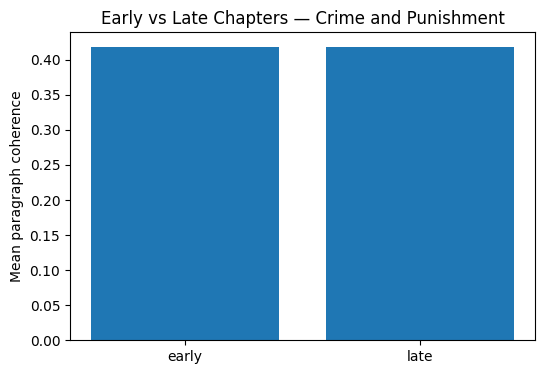

In [20]:
# --- Bar plot: early vs late chapter coherence ---

segments = ["early"] * len(early_scores) + ["late"] * len(late_scores)
all_scores = early_scores + late_scores

chap_compare_df = pd.DataFrame({
    "segment": segments,
    "coherence": all_scores,
})

mean_by_segment = chap_compare_df.groupby("segment")["coherence"].mean()

plt.figure(figsize=(6,4))
plt.bar(mean_by_segment.index, mean_by_segment.values)
plt.ylabel("Mean paragraph coherence")
plt.title("Early vs Late Chapters — Crime and Punishment")
plt.show()


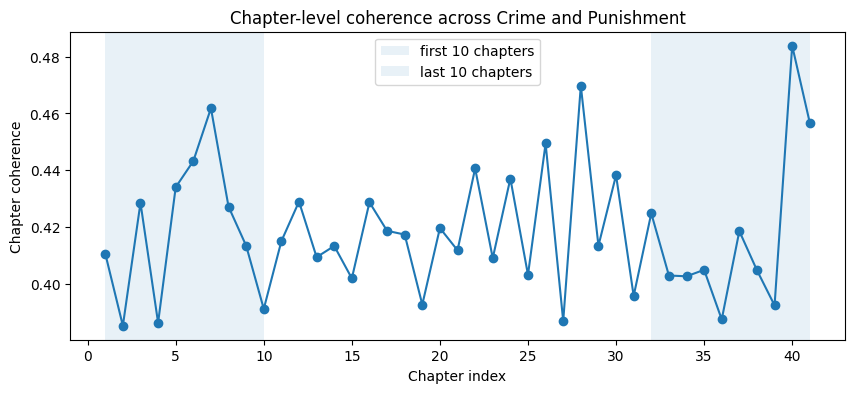

In [22]:
plt.figure(figsize=(10,4))
plt.plot(range(1, len(chapter_scores)+1), chapter_scores, marker="o")
plt.axvspan(1, 10, alpha=0.1, label="first 10 chapters")
plt.axvspan(len(chapter_scores)-9, len(chapter_scores), alpha=0.1, label="last 10 chapters")
plt.xlabel("Chapter index")
plt.ylabel("Chapter coherence")
plt.title("Chapter-level coherence across Crime and Punishment")
plt.legend()
plt.show()


In [23]:
import json
from pathlib import Path

char_path = Path("Character Library/Crime_punishment.json")
with open(char_path, "r", encoding="utf-8") as f:
    char_lib = json.load(f)

list(char_lib.keys())


['Rodion_Raskolnikov',
 'Sonia_Marmeladov',
 'Avdotya_Raskolnikov',
 'Arkady_Svidrigailov',
 'Dmitri_Razumikhin',
 'Pyotr_Luzhin',
 'Porfiry_Petrovich',
 'Semyon_Marmeladov',
 'Katerina_Ivanovna',
 'Alyona_Ivanovna',
 'Lizaveta_Ivanovna',
 'Pulcheria_Alexandrovna',
 'Zossimov',
 'Alexander_Zametov',
 'Andrey_Lebezyatnikov']

In [25]:
def collect_aliases(alias_list) -> list[str]:
    """
    Collect all alias strings from the 'aliases' list.
    Handles both plain strings and { "text": "...", "tier": ... } dicts.
    """
    names = []
    for item in alias_list:
        if isinstance(item, str):
            names.append(item)
        elif isinstance(item, dict) and "text" in item:
            names.append(item["text"])
    return [n.lower() for n in names]


In [26]:
rask_entry = char_lib["Rodion_Raskolnikov"]["aliases"]
sonia_entry = char_lib["Sonia_Marmeladov"]["aliases"]   # adjust key if needed

rask_aliases = collect_aliases(rask_entry)
sonia_aliases = collect_aliases(sonia_entry)

print("Rask aliases:", rask_aliases[:10])
print("Sonia aliases:", sonia_aliases[:10])


Rask aliases: ['raskolnikov', 'rodion romanovich raskolnikov', 'rodion romanovich', 'rodion', 'rodya', 'rodka', 'rodenka', 'the student', 'the young man', 'the lodger']
Sonia aliases: ['sonia', 'sonya', 'sofya semyonovna marmeladov', 'sofya semyonovna', 'marmeladova', 'sofya', 'sonechka', 'sonsyushka', "marmeladov's daughter", "katerina ivanovna's stepdaughter"]


In [32]:
def make_blocks_from_chapters(chapters, block_size: int = 5, min_words: int = 10):
    """
    Turn each chapter into blocks of `block_size` sentences.
    Keeps track of which chapter each block comes from.
    """
    blocks = []

    for idx, ch in enumerate(chapters, start=1):
        # split chapter into sentences
        pieces = re.split(r"(?<=[.!?])\s+", ch)
        sentences = [s.strip() for s in pieces if len(s.strip().split()) > 2]

        # group sentences into blocks
        for i in range(0, len(sentences), block_size):
            block = " ".join(sentences[i:i+block_size])
            if len(block.split()) >= min_words:
                blocks.append({
                    "chapter": idx,
                    "text": block,
                })

    return blocks

blocks = make_blocks_from_chapters(chapters, block_size=5)
len(blocks), blocks[0]["chapter"], blocks[0]["text"][:120]


(2571,
 1,
 'On an exceptionally hot evening early in July a young man came out of the garret in which he lodged in S. Place and walk')

In [33]:
block_texts = [b["text"] for b in blocks]

used_paras, block_scores, block_lengths = paragraph_coherence_embeddings(block_texts)

len(used_paras), len(block_scores), len(block_lengths)


(2571, 2571, 2571)

In [34]:
import pandas as pd

block_records = []
for b, score, length in zip(blocks, block_scores, block_lengths):
    block_records.append({
        "chapter": b["chapter"],
        "text": b["text"],
        "coherence": score,
        "length": length,
    })

blocks_df = pd.DataFrame(block_records)
blocks_df.head()


,chapter,text,coherence,length
0,1,On an exceptionally hot evening early in July ...,0.666653,97
1,1,"And each time he passed, the young man had a s...",0.748961,111
2,1,He had given up attending to matters of practi...,0.646485,120
3,1,"yes, all is in a man's hands and he lets it al...",0.597299,60
4,1,Or perhaps it is that I chatter because I do n...,0.572277,42


In [35]:
def label_block(text: str,
                rask_aliases: list[str],
                sonia_aliases: list[str]) -> str:
    t = text.lower()
    has_rask = any(alias in t for alias in rask_aliases)
    has_sonia = any(alias in t for alias in sonia_aliases)

    if has_rask and not has_sonia:
        return "raskolnikov"
    elif has_sonia and not has_rask:
        return "sonia"
    elif has_rask and has_sonia:
        return "both"
    else:
        return "other"

blocks_df["char_label"] = blocks_df["text"].apply(
    lambda txt: label_block(txt, rask_aliases, sonia_aliases)
)

blocks_df["char_label"].value_counts()


char_label
other          1497
raskolnikov     750
sonia           242
both             82
Name: count, dtype: int64

In [36]:
rask_blocks  = blocks_df[blocks_df["char_label"] == "raskolnikov"]
sonia_blocks = blocks_df[blocks_df["char_label"] == "sonia"]

print("Rask blocks:", len(rask_blocks))
print("Sonia blocks:", len(sonia_blocks))

rask_mean  = float(rask_blocks["coherence"].mean())
sonia_mean = float(sonia_blocks["coherence"].mean())

print(f"Raskolnikov mean coherence: {rask_mean:.3f}")
print(f"Sonia mean coherence:       {sonia_mean:.3f}")


Rask blocks: 750
Sonia blocks: 242
Raskolnikov mean coherence: 0.631
Sonia mean coherence:       0.630


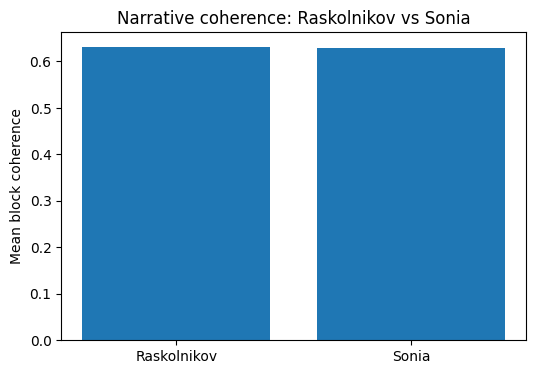

In [37]:
plt.figure(figsize=(6,4))
plt.bar(["Raskolnikov", "Sonia"], [rask_mean, sonia_mean])
plt.ylabel("Mean block coherence")
plt.title("Narrative coherence: Raskolnikov vs Sonia")
plt.show()


In [38]:
print("Raskolnikov coherence variance:", np.var(rask_blocks["coherence"]))
print("Sonia coherence variance:", np.var(sonia_blocks["coherence"]))


Raskolnikov coherence variance: 0.002025922652884177
Sonia coherence variance: 0.0021182152866054656
